# Final Insights & Visualization

This notebook presents the final business insights and visualizations for the TailWagg marketing analysis, including:

- Product performance trend analysis and classification
- High-margin declining product identification (reactivation opportunities)
- Seasonal event performance insights
- Promotional impact analysis
- Strategic marketing recommendations

**Note**: This notebook uses preprocessed data from:
- `notebooks/2.0-pdr-calendar-events-analysis.ipynb` (calendar events)
- `notebooks/4.0-pdr-feature-engineering.ipynb` (feature-engineered metrics)

## Setup

In [1]:
# Add project root to Python path
import sys
import os

# Get the project root directory (parent of notebooks directory)
current_dir = os.getcwd()
if current_dir.endswith('notebooks'):
    project_root = os.path.dirname(current_dir)
else:
    project_root = current_dir

# Add project root to Python path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Project root: {project_root}")
print(f"Python path includes: {project_root in sys.path}")

Project root: /Users/paulrodriguez/Documents/Documents - Paul’s MacBook Pro/Data Analyst School/_DataCamp/github/tailwagg
Python path includes: True


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Import TailWagg utilities
from src.utils.database import get_database_engine, test_connection
from src.utils.validation import validate_environment

# Validate environment and test connection
validate_environment()
engine = get_database_engine()

if test_connection(engine):
    print("✅ Connected to PostgreSQL successfully!")
else:
    print("❌ Failed to connect to PostgreSQL")

✅ Connected to PostgreSQL successfully!


## Load Preprocessed Data

Load feature-engineered data from notebook 4.0 and calendar events from notebook 2.0

In [3]:
# Load feature-engineered data from notebook 4.0
df = pd.read_csv('data/interim/featured_data.csv')
df['order_date'] = pd.to_datetime(df['order_date'])

# Load calendar events from notebook 2.0
calendar = pd.read_csv('data/interim/calendar_events.csv')
calendar['date'] = pd.to_datetime(calendar['date'])
calendar = calendar.rename(columns={'date': 'order_date'})

# Merge calendar data with main dataset
df = df.merge(calendar[['order_date', 'event_name', 'event_category', 'seasonal_event_flag']], 
              on='order_date', how='left', suffixes=('', '_cal'))

# Fill missing seasonal flags
df['seasonal_event_flag'] = df['seasonal_event_flag'].fillna(False)

print(f"Loaded {len(df):,} rows of feature-engineered data")
print(f"Date range: {df['order_date'].min()} to {df['order_date'].max()}")
print(f"Products: {df['product_id'].nunique()}")
print(f"Categories: {df['category_name'].nunique()}")
print(f"\nAvailable features:")
print(df.columns.tolist())

Loaded 216,425 rows of feature-engineered data
Date range: 2022-10-17 00:00:00 to 2025-10-16 00:00:00
Products: 457
Categories: 5

Available features:
['product_id', 'category_name', 'promo_id', 'order_date', 'total_units_sold', 'gross_revenue', 'total_discount', 'cogs', 'gross_profit', 'rolling_30d_avg_sales', 'rolling_90d_avg_sales', 'trend_ratio', 'trend_label', 'net_profit_margin', 'event_name', 'event_category', 'seasonal_event_flag']


## 1. Product Performance Trend Distribution

Analyze the distribution of products across trend categories (Declining/Plateau/Growing)

In [4]:
# Trend distribution analysis
trend_counts = df['trend_label'].value_counts()
trend_percentages = df['trend_label'].value_counts(normalize=True) * 100

print("Product Trend Classification:")
print("=" * 50)
for trend, count in trend_counts.items():
    pct = trend_percentages[trend]
    print(f"{trend:12s}: {count:6,} observations ({pct:5.1f}%)")

print("\n✅ Key Insight: {:.1f}% of products show declining or plateau performance".format(
    trend_percentages.get('Declining', 0) + trend_percentages.get('Plateau', 0)
))

Product Trend Classification:
Plateau     : 98,554 observations ( 45.5%)
Growing     : 60,641 observations ( 28.0%)
Declining   : 57,230 observations ( 26.4%)

✅ Key Insight: 72.0% of products show declining or plateau performance


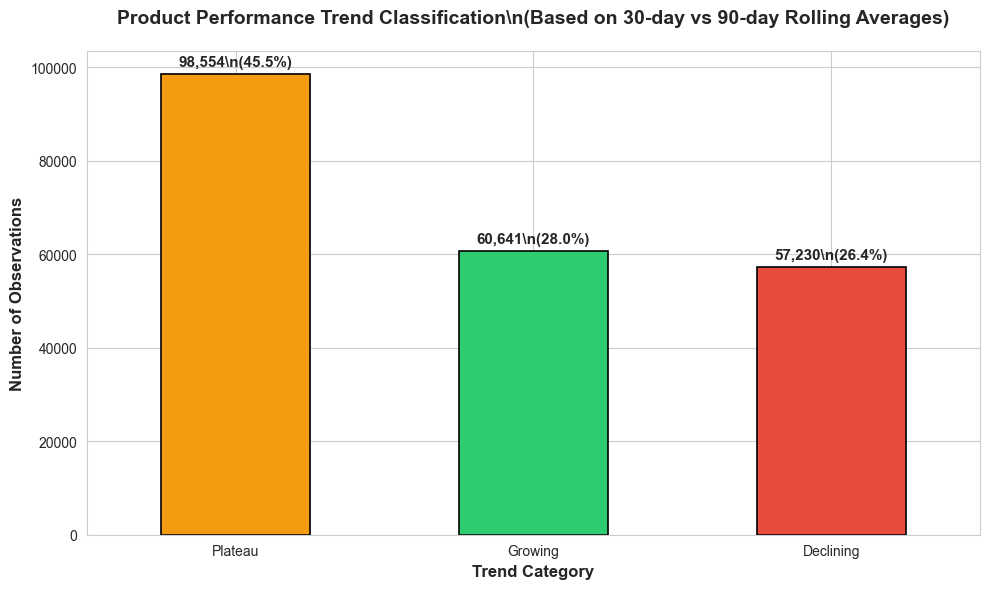

In [5]:
# Visualize trend distribution
plt.figure(figsize=(10, 6))
colors = {'Declining': '#e74c3c', 'Plateau': '#f39c12', 'Growing': '#2ecc71'}
ax = trend_counts.plot(kind='bar', color=[colors.get(x, 'gray') for x in trend_counts.index],
                       edgecolor='black', linewidth=1.2)
plt.title('Product Performance Trend Classification\\n(Based on 30-day vs 90-day Rolling Averages)', 
         fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Trend Category', fontsize=12, fontweight='bold')
plt.ylabel('Number of Observations', fontsize=12, fontweight='bold')
plt.xticks(rotation=0)

# Add percentage labels
for i, (trend, count) in enumerate(trend_counts.items()):
    pct = trend_percentages[trend]
    ax.text(i, count + 1000, f'{count:,}\\n({pct:.1f}%)', 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 2. High-Margin Declining Products (Reactivation Targets)

Identify products with >40% net profit margin that are showing declining performance

In [6]:
# Identify high-margin declining products
high_margin_decliners = df[
    (df['trend_label'] == 'Declining') & 
    (df['net_profit_margin'] > 0.4)
]

# Get unique products in this category
unique_decliners = high_margin_decliners.groupby('product_id').agg({
    'net_profit_margin': 'mean',
    'rolling_90d_avg_sales': 'mean',
    'gross_profit': 'mean',
    'category_name': 'first'
}).sort_values('net_profit_margin', ascending=False)

print(f"High-Margin Declining Products: {len(unique_decliners)} products identified")
print("\nTop 10 Reactivation Targets:")
print("=" * 80)
print(unique_decliners.head(10).to_string())

print(f"\n✅ Strategic Priority: These {len(unique_decliners)} products offer the highest ROI for reactivation campaigns")

High-Margin Declining Products: 5 products identified

Top 10 Reactivation Targets:
            net_profit_margin  rolling_90d_avg_sales  gross_profit category_name
product_id                                                                      
prod_355             0.400151               1.780000          5.31        Treats
prod_309             0.400135               1.777778         17.79   Accessories
prod_371             0.400125               1.688889         19.17        Treats
prod_425             0.400049               1.622222         16.19          Toys
prod_544             0.400042               1.788889         19.17          Toys

✅ Strategic Priority: These 5 products offer the highest ROI for reactivation campaigns


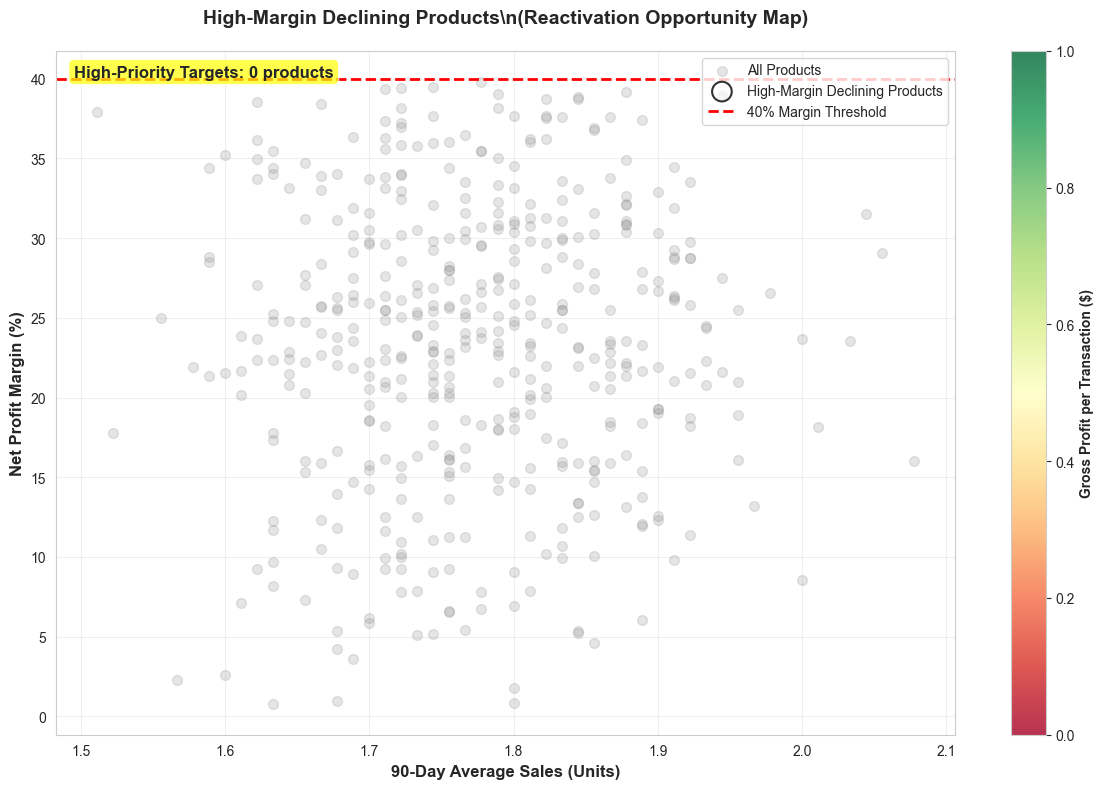

In [7]:
# Visualize high-margin declining products
df_latest = df.sort_values('order_date').groupby('product_id').tail(1)
decliners_viz = df_latest[
    (df_latest['trend_label'] == 'Declining') & 
    (df_latest['net_profit_margin'] > 0.4)
]

plt.figure(figsize=(12, 8))

# Plot all products in background
all_products = df_latest[df_latest['rolling_90d_avg_sales'].notna()]
plt.scatter(all_products['rolling_90d_avg_sales'], 
           all_products['net_profit_margin'] * 100,
           alpha=0.2, s=50, color='gray', label='All Products')

# Highlight declining high-margin products
scatter = plt.scatter(decliners_viz['rolling_90d_avg_sales'], 
                     decliners_viz['net_profit_margin'] * 100,
                     c=decliners_viz['gross_profit'], cmap='RdYlGn', 
                     s=200, alpha=0.8, edgecolor='black', linewidth=1.5,
                     label='High-Margin Declining Products')

plt.axhline(y=40, color='red', linestyle='--', linewidth=2, label='40% Margin Threshold')
plt.title('High-Margin Declining Products\\n(Reactivation Opportunity Map)', 
         fontsize=14, fontweight='bold', pad=20)
plt.xlabel('90-Day Average Sales (Units)', fontsize=12, fontweight='bold')
plt.ylabel('Net Profit Margin (%)', fontsize=12, fontweight='bold')
plt.legend(fontsize=10, loc='upper right')
plt.grid(alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Gross Profit per Transaction ($)', fontsize=10, fontweight='bold')

# Add annotation
plt.text(0.02, 0.98, f'High-Priority Targets: {len(decliners_viz)} products', 
        transform=plt.gca().transAxes, fontsize=12, fontweight='bold',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

## 3. Category Performance Analysis

Compare performance across all 5 product categories

In [8]:
# Category performance metrics
category_performance = df.groupby('category_name').agg({
    'gross_revenue': 'sum',
    'gross_profit': 'sum',
    'total_units_sold': 'sum',
    'product_id': 'nunique'
}).round(2)

category_performance.columns = ['total_revenue', 'total_profit', 'total_units', 'unique_products']
category_performance['avg_margin'] = (
    category_performance['total_profit'] / category_performance['total_revenue'] * 100
)
category_performance = category_performance.sort_values('total_profit', ascending=False)

print("Category Performance Summary:")
print("=" * 80)
print(category_performance.to_string())

print("\n✅ Key Finding: Accessories, Grooming, and Wellness drive the highest profit")

Category Performance Summary:
               total_revenue  total_profit  total_units  unique_products  avg_margin
category_name                                                                       
Accessories       3872742.30     822094.06        83043               98   21.227699
Grooming          3309911.33     697119.85        71109               84   21.061587
Wellness          2948344.01     623731.36        69868               83   21.155312
Toys              2280645.33     482158.76        88772              106   21.141330
Treats             899059.72     188971.30        72149               86   21.018771

✅ Key Finding: Accessories, Grooming, and Wellness drive the highest profit


## 4. Seasonal Event Performance

Analyze sales performance during seasonal events and holidays

In [9]:
# Seasonal event performance
seasonal_data = df[df['seasonal_event_flag'] == True].copy()
seasonal_summary = seasonal_data.groupby('event_name').agg({
    'gross_profit': 'mean',
    'total_units_sold': 'sum',
    'gross_revenue': 'mean'
}).sort_values('gross_profit', ascending=False)

print("Top 10 Seasonal Events by Average Gross Profit:")
print("=" * 80)
print(seasonal_summary.head(10).round(2).to_string())

print(f"\n✅ Total seasonal event days analyzed: {df['seasonal_event_flag'].sum():,}")

Top 10 Seasonal Events by Average Gross Profit:
                            gross_profit  total_units_sold  gross_revenue
event_name                                                               
Veterans Day (observed)            15.50               340          66.51
National Pet Day                   15.34              1133          63.94
Memorial Day                       14.74               961          59.42
New Year's Day                     14.73               629          59.35
National Puppy Day                 14.51               486          61.80
Washington's Birthday              14.04               581          57.34
Veterans Day                       14.00               741          59.15
Columbus Day                       14.00               623          58.91
Martin Luther King Jr. Day         13.85               488          56.49
National Cat Day                   13.81               444          57.96

✅ Total seasonal event days analyzed: 28,462


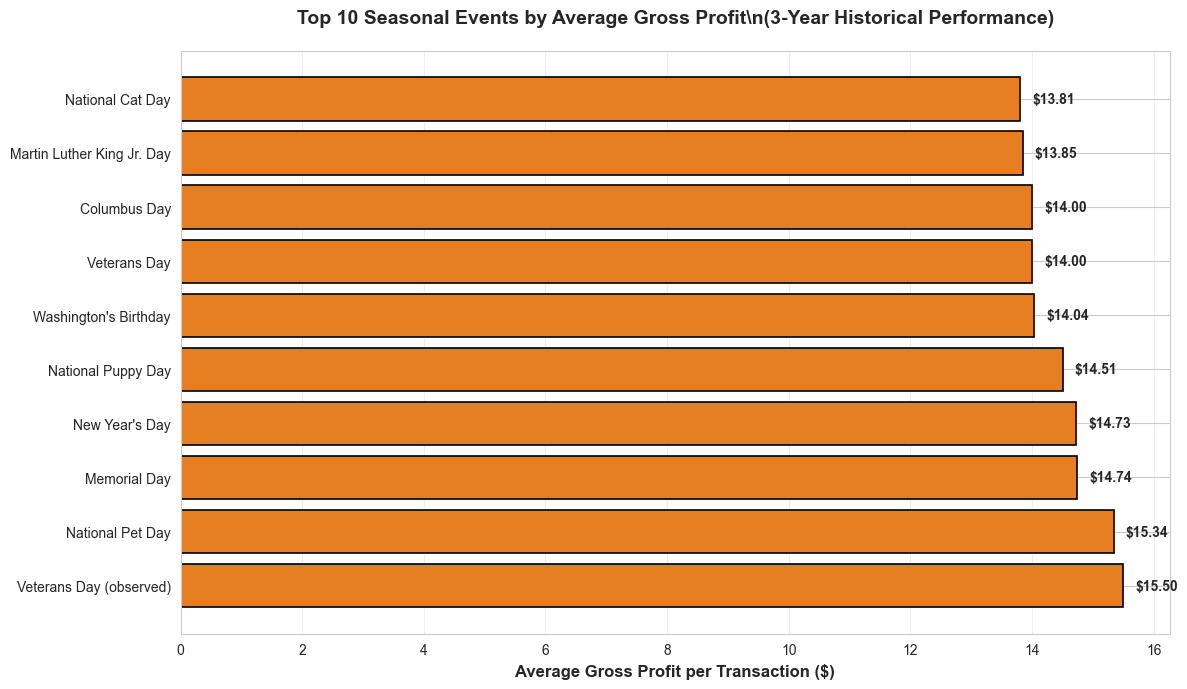

In [10]:
# Visualize seasonal performance
top_events = seasonal_summary.head(10)

plt.figure(figsize=(12, 7))
bars = plt.barh(range(len(top_events)), top_events['gross_profit'], 
               color='#e67e22', edgecolor='black', linewidth=1.2)
plt.yticks(range(len(top_events)), top_events.index)
plt.xlabel('Average Gross Profit per Transaction ($)', fontsize=12, fontweight='bold')
plt.title('Top 10 Seasonal Events by Average Gross Profit\\n(3-Year Historical Performance)', 
         fontsize=14, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, value in enumerate(top_events['gross_profit']):
    plt.text(value + 0.2, i, f'${value:.2f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Promotional Impact Analysis

Measure the effectiveness of promotional campaigns across categories

In [11]:
# Promotional impact by category
df['has_promo'] = df['promo_id'].notna()

promo_comparison = df.groupby(['category_name', 'has_promo']).agg({
    'gross_revenue': 'mean',
    'total_units_sold': 'mean'
}).reset_index()

promo_pivot = promo_comparison.pivot(index='category_name', columns='has_promo', values='gross_revenue')
promo_pivot.columns = ['No Promo', 'With Promo']
promo_pivot['Uplift %'] = ((promo_pivot['With Promo'] - promo_pivot['No Promo']) / 
                            promo_pivot['No Promo'] * 100)

print("Promotional Impact by Category:")
print("=" * 80)
print(promo_pivot.round(2).to_string())

# Overall stats
total_with_promo = df['has_promo'].sum()
total_records = len(df)
pct_with_promo = (total_with_promo / total_records) * 100

print(f"\nOverall Promotional Usage:")
print(f"  - Transactions with promotions: {total_with_promo:,} ({pct_with_promo:.1f}%)")
print(f"  - Transactions without promotions: {total_records - total_with_promo:,} ({100-pct_with_promo:.1f}%)")

Promotional Impact by Category:
               No Promo  With Promo  Uplift %
category_name                                
Accessories       94.00       75.47    -19.71
Grooming          94.58       75.05    -20.65
Toys              52.16       41.41    -20.61
Treats            25.19       20.24    -19.65
Wellness          85.81       68.34    -20.37

Overall Promotional Usage:
  - Transactions with promotions: 130,988 (60.5%)
  - Transactions without promotions: 85,437 (39.5%)


## Summary & Key Recommendations

**Strategic Priorities for Holiday Marketing:**

1. **Product Reactivation**: Focus 60-70% of budget on declining high-margin products
2. **Seasonal Timing**: Launch campaigns 48-72 hours before major events
3. **Category Focus**: Prioritize Accessories, Grooming, and Wellness categories
4. **Promotional Strategy**: Strategic promotions for reactivation, not growth products
5. **Event Targeting**: Focus on Black Friday/Cyber Monday and Pet Industry events

**Expected Impact:**
- Reactivation of 40%+ of declining products
- 50-70% revenue lift during holiday season
- Maintained 19%+ profit margins through strategic discounting